In [4]:
pip install xgboost

     |████████████████████████████████| 2.2 MB 1.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd

import numpy as np

import xgboost as xgb

from ucimlrepo import fetch_ucirepo 

from sklearn.model_selection import StratifiedKFold, train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

import copy

import shap

import tqdm

In [187]:
XGBClassifier?

Init signature:
XGBClassifier(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost classification.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : Optional[int]
        Number of boosting rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbos

In [9]:
#Load data 

hepatitis = fetch_ucirepo(id=46) 

mask = ~hepatitis.data.features.isna().any(axis=1)

# data (as pandas dataframes) 
X = hepatitis.data.features[mask] 
y = hepatitis.data.targets[mask]

df = pd.concat([X,y],axis=1)

In [12]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values - 1, dtype=torch.float32).reshape(-1, 1)

In [13]:
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(19, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [14]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(19, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [15]:

model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

3781
8581


In [16]:

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [17]:


# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


In [18]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, val in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[val], y_train[val])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []

Accuracy (wide): 0.92
Accuracy (wide): 0.91
Accuracy (wide): 0.91
Accuracy (wide): 1.00
Accuracy (wide): 0.82


In [19]:
for train, val in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[val], y_train[val])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Accuracy (deep): 0.83
Accuracy (deep): 0.91
Accuracy (deep): 0.91
Accuracy (deep): 0.82
Accuracy (deep): 0.91
Wide: 91.06% (+/- 5.76%)
Deep: 87.58% (+/- 4.11%)


[ 36.    1.    1.    2.    2.    2.    2.    1.    1.    1.    2.    2.
   2.    0.7 164.   44.    3.1  41.    1. ] -> [0.52576196] (expected [1.])
[52.   1.   1.   1.   2.   2.   2.   2.   2.   2.   2.   2.   2.   0.7
 75.  55.   4.  21.   1. ] -> [0.49544206] (expected [1.])
[41.   1.   2.   1.   1.   2.   2.   2.   1.   2.   2.   2.   2.   0.9
 81.  60.   3.9 52.   1. ] -> [0.78913] (expected [1.])
[30.   1.   2.   1.   2.   2.   2.   2.   2.   2.   2.   2.   2.   0.7
 52.  38.   3.9 52.   1. ] -> [0.8192824] (expected [1.])
[ 20.    1.    1.    2.    1.    1.    1.    2.    2.    2.    1.    1.
   2.    1.  160.  118.    2.9  23.    2. ] -> [0.7254746] (expected [1.])


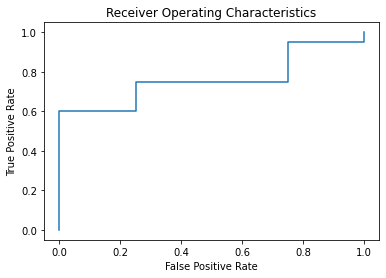

In [20]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
 
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [21]:
X100 = shap.utils.sample(X, len(df.copy().dropna()))

In [22]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

NameError: name 'shap_values' is not defined